## Clinical Data Preprocessing

Load → Split → Impute/Scale (KNN + QuantileTransformer) → Save

In [ ]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data_loader import ClinicalDataLoader
from src.features import ClinicalPreprocessor

RAW_PATH = Path("../data/raw/dataset.xlsx")
OUT_PATH = Path("../data/processed/01_cleaned_advanced.csv")
FIG_DIR = Path("../figures")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Pipeline: Load -> Split -> Impute/Scale
loader = ClinicalDataLoader(RAW_PATH)
features, meta = loader.load_cohort(min_labs=10, max_missing=0.9)

preprocessor = ClinicalPreprocessor(n_neighbors=5, output_distribution="normal")
X_transformed, _ = preprocessor.fit_transform(features)

# Combine with metadata for downstream use
output = meta.copy()
for c in X_transformed.columns:
    output[c] = X_transformed[c].values

output.to_csv(OUT_PATH, index=False)
print(f"Saved: {OUT_PATH} | Shape: {output.shape}")

Saved: ..\data\processed\01_cleaned_advanced.csv | Shape: (603, 51)


c:\Users\amitf\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (603). n_quantiles is set to n_samples.
  warnings.warn(


### Before vs After: Leukocytes

The histogram below proves that the QuantileTransformer normalizes the distribution.

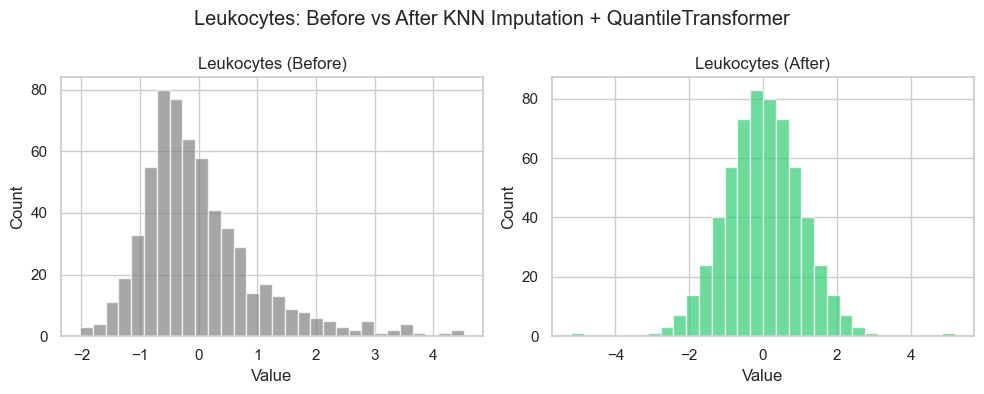

In [ ]:
from src.visualization import plot_before_after_histogram

feat_name = "Leukocytes"
if feat_name in features.columns and feat_name in X_transformed.columns:
    plot_before_after_histogram(
        features[feat_name],
        X_transformed[feat_name],
        feature_name=feat_name,
        title="Leukocytes: Before vs After KNN Imputation + QuantileTransformer",
        save_path=str(FIG_DIR / "leukocytes_before_after.png"),
    )
else:
    print(f"'{feat_name}' not found. Available: {list(features.columns[:5])}...")

---

In [31]:
# Legacy sections consolidated above (Load -> Split -> Impute/Scale -> Save)

---

In [ ]:
# Legacy

---

In [33]:
# Legacy

---

In [34]:
from sklearn.impute import KNNImputer

missing_frac = df[feature_cols].isna().mean()
feature_cols = missing_frac[missing_frac < 0.90].index.tolist()

# Advanced imputation: KNN preserves multivariate relationships between labs
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df[feature_cols])
imputed_df = pd.DataFrame(imputed, columns=feature_cols, index=df.index)

---

In [35]:
# Note: Although the hospital data are approximately Z-scored, our selected cohort (N=603)
# can have shifted distributions. We apply a QuantileTransformer (to a normal output
# distribution) instead of hard clipping to better handle skewed medical variables.
transformer = QuantileTransformer(output_distribution="normal", random_state=42)
transformed = transformer.fit_transform(imputed_df)

processed = df.copy()
processed[feature_cols] = transformed

NameError: name 'QuantileTransformer' is not defined

---

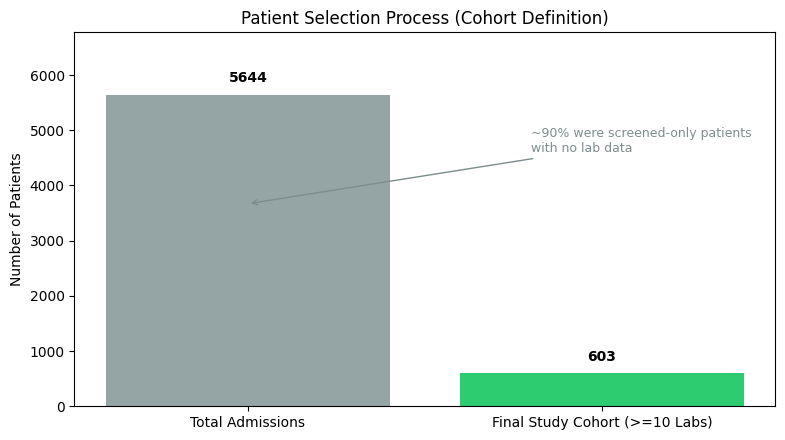

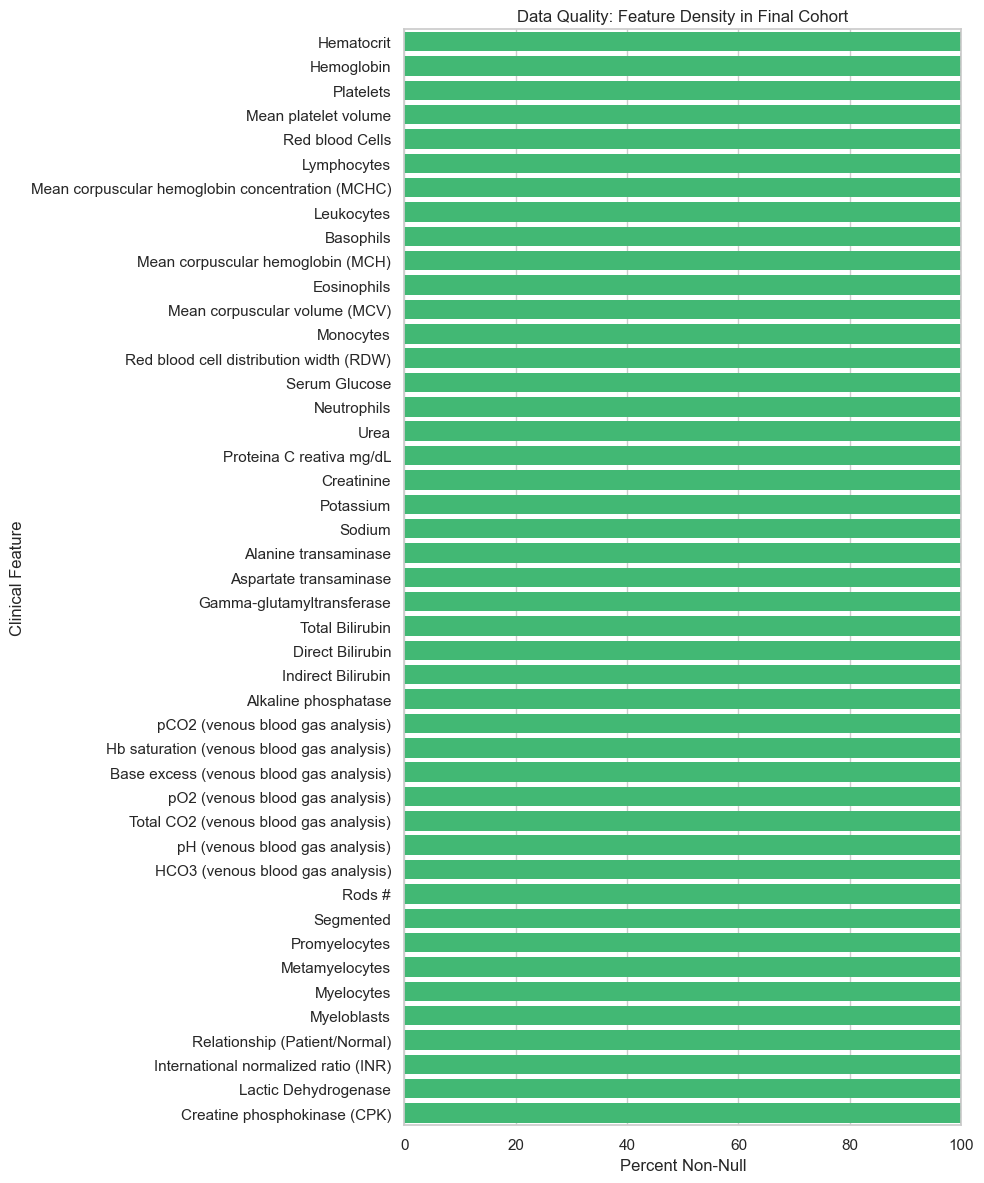

Saved cleaned data with shape: (603, 111)


In [ ]:
# Patient selection funnel
total_admissions = raw_df.shape[0]
final_cohort = processed.shape[0]

cohort_labels = [
    "Total Admissions",
    "Final Study Cohort (>=10 Labs)",
]
cohort_values = [total_admissions, final_cohort]
cohort_colors = ["#95a5a6", "#2ecc71"]

plt.figure(figsize=(8, 4.5))
ax = plt.bar(cohort_labels, cohort_values, color=cohort_colors, edgecolor="none")
plt.title("Patient Selection Process (Cohort Definition)")
plt.ylabel("Number of Patients")
plt.ylim(0, max(cohort_values) * 1.2)

for bar, value in zip(ax, cohort_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(cohort_values) * 0.03,
        f"{value}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.annotate(
    "~90% were screened-only patients\nwith no lab data",
    xy=(0, cohort_values[0] * 0.65),
    xytext=(0.8, cohort_values[0] * 0.85),
    textcoords="data",
    arrowprops={"arrowstyle": "->", "color": "#7f8c8d"},
    ha="left",
    va="center",
    fontsize=9,
    color="#7f8c8d",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "cohort_selection_funnel.png", dpi=300)
plt.show()

# Data density plot (final cohort)
completeness = processed[feature_cols].notna().mean().mul(100).sort_values()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 12))
ax = sns.barplot(
    x=completeness.values,
    y=completeness.index,
    color="#2ecc71",
    edgecolor="none",
)
ax.axvline(100, color="black", linestyle="--", linewidth=1)
ax.set_xlim(0, 100)
ax.set_xlabel("Percent Non-Null")
ax.set_ylabel("Clinical Feature")
ax.set_title("Data Quality: Feature Density in Final Cohort")
plt.tight_layout()
plt.savefig(FIG_DIR / "data_quality_feature_density.png", dpi=300)
plt.show()

# Save processed data (standard and advanced export)
processed.to_csv(OUT_PATH, index=False)
processed.to_csv(ADV_OUT_PATH, index=False)
print(f"Saved cleaned data with shape: {processed.shape}")